In [ ]:
%pip install openai

In [35]:
import pandas as pd
import re

from tqdm.notebook import tqdm
from openai import OpenAI
import json
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate


import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset from a Google sheet.

In [30]:
# ## CHANGE THIS IF YOU WANT
# GOOGLE_SPREADSHEET_LINK = "https://docs.google.com/spreadsheets/d/1rNhxGcKdDnWhLzD8WhOLoR62STgK8NYtrTv6NfCFWLw/edit?usp=sharing"

# sheet_id = GOOGLE_SPREADSHEET_LINK.split("/")[5]

# url=f'https://docs.google.com/spreadsheet/ccc?key={sheet_id}&output=xlsx'
# dataset_train = pd.read_excel(url, sheet_name="train")
# dataset_test = pd.read_excel(url, sheet_name="test")

# print("Train data size:", len(dataset_train))
# print("Test data size:", len(dataset_test))

# # encode categorical variables
# columns_to_encode = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]
# dataset_train = pd.get_dummies(dataset_train, columns=columns_to_encode)
# dataset_test = pd.get_dummies(dataset_test, columns=columns_to_encode)

# dataset_train

df = pd.read_csv("Food_Delivery_Times.csv")
columns_to_encode = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]
df = pd.get_dummies(df, columns=columns_to_encode)
df


,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,522,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,738,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,741,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,661,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,412,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,107,8.50,13,3.0,54,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False
996,271,16.28,8,9.0,71,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True
997,861,15.62,26,2.0,81,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True
998,436,14.17,8,0.0,55,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False


In [31]:
df[["Time_of_Day_Morning", "Time_of_Day_Afternoon",]]

,Time_of_Day_Morning,Time_of_Day_Afternoon
0,False,True
1,False,False
2,False,False
3,False,True
4,True,False
...,...,...
995,False,False
996,True,False
997,False,False
998,False,True


In [49]:
features = ["Distance_km", "Preparation_Time_min", "Courier_Experience_yrs", "Weather_Clear", "Weather_Rainy", "Weather_Foggy", "Weather_Snowy", "Weather_Windy", "Traffic_Level_Low", "Traffic_Level_Medium", "Traffic_Level_High",
            "Time_of_Day_Morning", "Time_of_Day_Afternoon", "Time_of_Day_Evening", "Time_of_Day_Night", "Vehicle_Type_Car", "Vehicle_Type_Bike", "Vehicle_Type_Scooter"]# 1. Setup

X = df[features]
y = df["Delivery_Time_min"]

clf = RandomForestRegressor(n_estimators=100, random_state=42)
kf  = KFold(n_splits=10, shuffle=True, random_state=42)

# 2. Run cross‐validation and keep each fitted estimator
cv_results = cross_validate(
    clf,
    X, 
    y,
    cv=kf,
    scoring='neg_mean_absolute_error',
    return_estimator=True
)

# 3. Extract and score them
estimators = cv_results['estimator']
maes       = -cv_results['test_score']           # positive MAEs
best_idx   = np.argmin(maes)                     # index of lowest MAE
best_model = estimators[best_idx]

all_splits = list(kf.split(X))             
train_idx, test_idx = all_splits[best_idx]

X_train = X.iloc[train_idx]
X_test  = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

print(f"Best fold: {best_idx+1}  MAE: {maes[best_idx]:.2f}")

# find rmse and r2 of the best model
from sklearn.metrics import mean_squared_error, r2_score
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Best fold: 2  MAE: 5.68
Root Mean Squared Error: 7.81
R^2 Score: 0.85


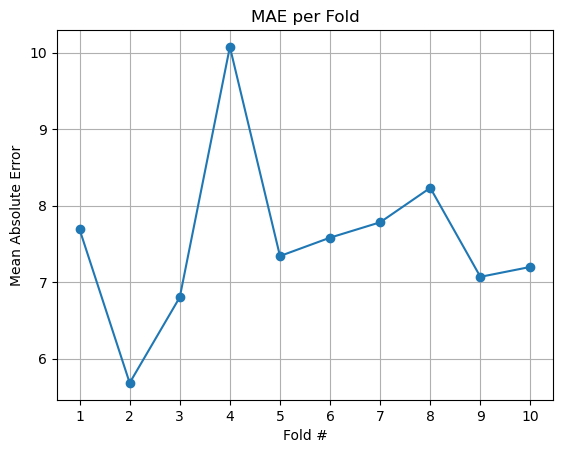

In [47]:
# mae_scores is your array of per-fold MAEs
import matplotlib.pyplot as plt

folds = list(range(1, len(maes) + 1))

plt.figure()
plt.plot(folds, maes, marker='o')        # line plot

plt.title("MAE per Fold")
plt.xlabel("Fold #")
plt.ylabel("Mean Absolute Error")
plt.xticks(folds)                               # ensure each fold shows up on the x-axis
plt.grid(True)                                  # optional, makes it easier to read
plt.show()


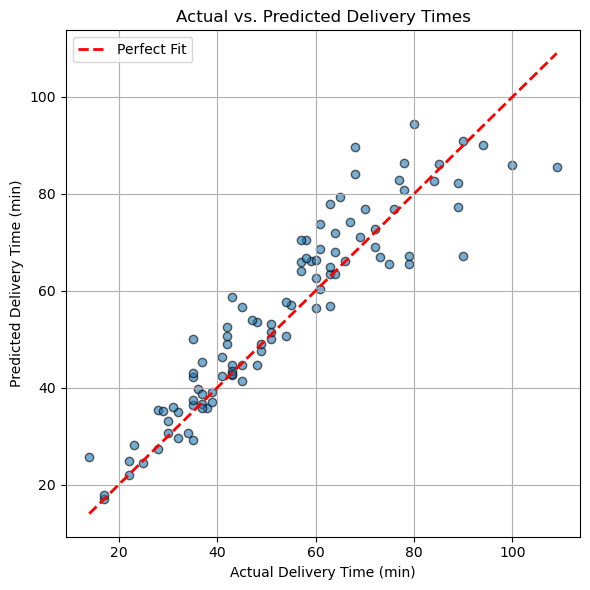

In [57]:

# 4. scatter actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')

# 5. plot the perfect‐prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val],
         [min_val, max_val],
         'r--', lw=2, label='Perfect Fit')

plt.xlabel("Actual Delivery Time (min)")
plt.ylabel("Predicted Delivery Time (min)")
plt.title("Actual vs. Predicted Delivery Times")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# predictions = clf.predict(Xtest)

# mae = np.mean(np.abs(predictions - ytest))
# print("Mean absolute error:", mae)

# rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
# print("Root mean squared error:", rmse)

Mean absolute error: 5.8618181818181805
Root mean squared error: 7.01281294877779


## ALT METHOD

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [ ]:
## CHANGE THIS IF YOU WANT
GOOGLE_SPREADSHEET_LINK = "https://docs.google.com/spreadsheets/d/1rNhxGcKdDnWhLzD8WhOLoR62STgK8NYtrTv6NfCFWLw/edit?usp=sharing"

sheet_id = GOOGLE_SPREADSHEET_LINK.split("/")[5]

url=f'https://docs.google.com/spreadsheet/ccc?key={sheet_id}&output=xlsx'
df = pd.read_excel(url, sheet_name="train")
dataset_test = pd.read_excel(url, sheet_name="test")

df


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...,...
984,373,2.34,Foggy,Medium,Morning,Bike,8,2.0,28
985,88,12.93,Clear,Medium,Morning,Scooter,20,8.0,58
986,459,1.60,Clear,Medium,Evening,Bike,14,8.0,24
987,331,7.44,Rainy,Low,Evening,Bike,27,NaN,53


In [ ]:
df['Distance_km_fx'] = pd.cut(df['Distance_km'], bins=[0, 5.1050, 10.1900, 15.0175, np.inf],
                              labels=['near', 'ok', 'far', 'very far'])
# Creating Delivery_Time_min_fx on df
df['Delivery_Time_min_fx'] = pd.cut(df['Delivery_Time_min'], bins=[0, 41, 55.5, 71, np.inf],
                              labels=['fast', 'ok', 'low', 'very low'])
# It reflects that a distance of 5 km in high traffic is "worth more" than 5 km in low traffic.
traffic_map = {'Low': 1, 'Medium': 1.5, 'High': 2}
df['Traffic_Factor'] = df['Traffic_Level'].map(traffic_map)
df['Effective_Distance'] = df['Distance_km'] * df['Traffic_Factor']
# Creating a feature to try improve de model
df['Is_Bad_Weather'] = df['Weather'].isin(['Rainy', 'Snowy', 'Foggy']).astype(int)
# Calculate Median
median_distance = df['Distance_km'].median()
# Create a boolean feature
df['Is_Long_Distance'] = (df['Distance_km'] > median_distance).astype(int)

df.drop(['Order_ID', 'Is_Long_Distance', 'Is_Bad_Weather',
       'Traffic_Factor'], axis=1, inplace=True)
X, y = df.drop('Delivery_Time_min', axis=1), df['Delivery_Time_min']
X.columns


Index(['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Distance_km_fx', 'Delivery_Time_min_fx', 'Effective_Distance'],
      dtype='object')

In [ ]:
imp_avg = ['Courier_Experience_yrs']
imp_cat = ['Weather', 'Traffic_Level', 'Time_of_Day']
cols_onehot = ['imp_cat__Weather', 'imp_cat__Traffic_Level', 'imp_cat__Time_of_Day', 'remainder__Vehicle_Type', 'remainder__Delivery_Time_min_fx',
              'remainder__Distance_km_fx']
pipeline = Pipeline(
    steps=[
        # Imputing missing values
        ('imp', ColumnTransformer(
            transformers = [
                # name, imputation strategy and columns
                # set_output to transform on a table again after .fit_transform
                ('imp_num', SimpleImputer(strategy='mean').set_output(transform='pandas'), imp_avg),
                ('imp_cat', SimpleImputer(strategy='most_frequent').set_output(transform='pandas'), imp_cat)
            ]
        , remainder = 'passthrough').set_output(transform='pandas')),
        # OneHotEncoding to categorical features
        ('cat', ColumnTransformer(
            transformers=[
                ('ohe', OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas'), cols_onehot)
            ]
        , remainder='passthrough').set_output(transform='pandas')),
        ('norm', PowerTransformer(method='yeo-johnson').set_output(transform='pandas')),
        ('scale', StandardScaler().set_output(transform='pandas'))
    ])
X = pipeline.fit_transform(X)
# Split data on train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = xgb.XGBRegressor(random_state=42)

model = TransformedTargetRegressor(
    regressor=model,
    transformer=StandardScaler()
)

# Search best params
param_grid = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'regressor__subsample': [0.6, 0.8, 1],
    'regressor__colsample_bytree': [0.6, 0.8, 1],
    'regressor__gamma': [0, 0.1, 0.2]
}


search = RandomizedSearchCV(model, param_grid, n_iter=30, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_
best_model

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=1,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None, gamma=0.2,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.1,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=7, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=300, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...),
                           transformer=StandardScaler())

In [ ]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2: {r2:.2f}')
print(f'Raiz Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 4.48
Mean Squared Error: 43.25
R2: 0.91
Raiz Mean Squared Error: 6.58
